## What is RAG?

RAG stands for Retrieval Augmented Generation.

It was introduced in the paper [*Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks*](https://arxiv.org/abs/2005.11401).

Each step can be roughly broken down to:

* **Retrieval** - Seeking relevant information from a source given a query. For example, getting relevant passages of Wikipedia text from a database given a question.
* **Augmented** - Using the relevant retrieved information to modify an input to a generative model (e.g. an LLM).
* **Generation** - Generating an output given an input. For example, in the case of an LLM, generating a passage of text given an input prompt.

I have stolen the below image from this NVIDIA blog:
https://developer.nvidia.com/blog/rag-101-demystifying-retrieval-augmented-generation-pipelines/

I wont be using the LlamaIndex or Langchain or the below framework. I will actually be writing it in puthon and storing the embeddings in pandas rather than VECTOR DB and then Doing the propmt engineering.

If you want to use the LLAMA Langchain here is the link to the GITrepo mentioned in that nvidia blog:
https://github.com/NVIDIA/GenerativeAIExamples/tree/main/RAG/notebooks

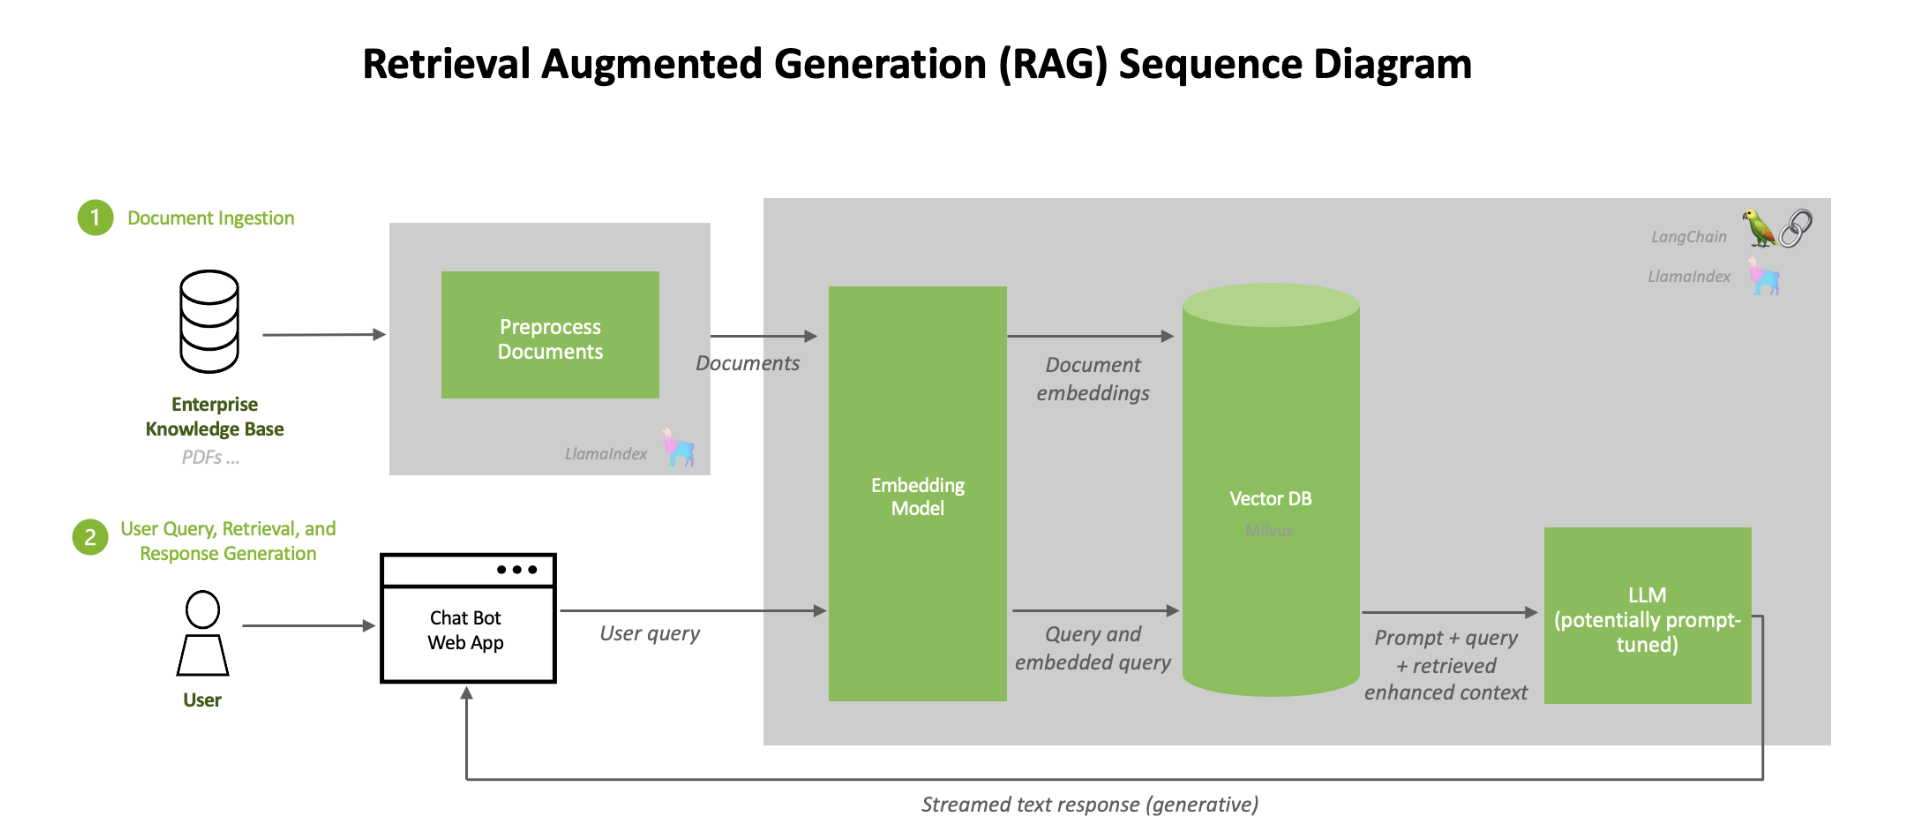

## Key terms

| Term | Description |
| ----- | ----- | 
| **Token** | A sub-word piece of text. For example, "hello, world!" could be split into ["hello", ",", "world", "!"]. A token can be a whole word,<br> part of a word or group of punctuation characters. 1 token ~= 4 characters in English, 100 tokens ~= 75 words.<br> Text gets broken into tokens before being passed to an LLM. |
| **Embedding** | A learned numerical representation of a piece of data. For example, a sentence of text could be represented by a vector with<br> 768 values. Similar pieces of text (in meaning) will ideally have similar values. |
| **Embedding model** | A model designed to accept input data and output a numerical representation. For example, a text embedding model may take in 384 <br>tokens of text and turn it into a vector of size 768. An embedding model can and often is different to an LLM model. |
| **Similarity search/vector search** | Similarity search/vector search aims to find two vectors which are close together in high-demensional space. For example, <br>two pieces of similar text passed through an embedding model should have a high similarity score, whereas two pieces of text about<br> different topics will have a lower similarity score. Common similarity score measures are dot product and cosine similarity. |
| **Large Language Model (LLM)** | A model which has been trained to numerically represent the patterns in text. A generative LLM will continue a sequence when given a sequence. <br>For example, given a sequence of the text "hello, world!", a genertive LLM may produce "we're going to build a RAG pipeline today!".<br> This generation will be highly dependant on the training data and prompt. |
| **LLM context window** | The number of tokens a LLM can accept as input. For example, as of March 2024, GPT-4 has a default context window of 32k tokens<br> (about 96 pages of text) but can go up to 128k if needed. A recent open-source LLM from Google, Gemma (March 2024) has a context<br> window of 8,192 tokens (about 24 pages of text). A higher context window means an LLM can accept more relevant information<br> to assist with a query. For example, in a RAG pipeline, if a model has a larger context window, it can accept more reference items<br> from the retrieval system to aid with its generation. |
| **Prompt** | A common term for describing the input to a generative LLM. The idea of "[prompt engineering](https://en.wikipedia.org/wiki/Prompt_engineering)" is to structure a text-based<br> (or potentially image-based as well) input to a generative LLM in a specific way so that the generated output is ideal. This technique is<br> possible because of a LLMs capacity for in-context learning, as in, it is able to use its representation of language to breakdown <br>the prompt and recognize what a suitable output may be (note: the output of LLMs is probable, so terms like "may output" are used). | 




In [1]:
import sys 
import platform
import os
import requests
import numpy as np 
import pandas as pd 
import re 
from tqdm import tqdm
import torch

In [2]:
# What version of Python do you have?
print(f"python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")
print(f"Python: {sys.version}")
print(f"Pandas: {pd.__version__}")

python Platform: macOS-15.4.1-arm64-arm-64bit
PyTorch Version: 2.6.0
Python: 3.11.7 (main, Dec 15 2023, 12:09:56) [Clang 14.0.6 ]
Pandas: 2.2.1


In [3]:
def get_device():
    has_gpu = torch.cuda.is_available()
    has_mps = torch.backends.mps.is_built()
    print ("NVIDIA/CUDA GPU is", "available" if has_gpu else "NOT AVAILABLE")
    print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
    return torch.device('mps') if has_mps else torch.device('cuda') if has_gpu else torch.device('cpu')
device = get_device()
print(f"Target device is {device}")

NVIDIA/CUDA GPU is NOT AVAILABLE
MPS (Apple Metal) is AVAILABLE
Target device is mps


## 1. Document/Text Processing and Embedding Creation

### Import PDF Document 

#### Link below is the book I will be interacting with via RAG:
https://pressbooks.oer.hawaii.edu/humannutrition2/

* **Human Nutrition: 2020 Edition:** - To download the pdf file on the fly we need to click on drop down of Download this book and click on **inspect** to get the download link

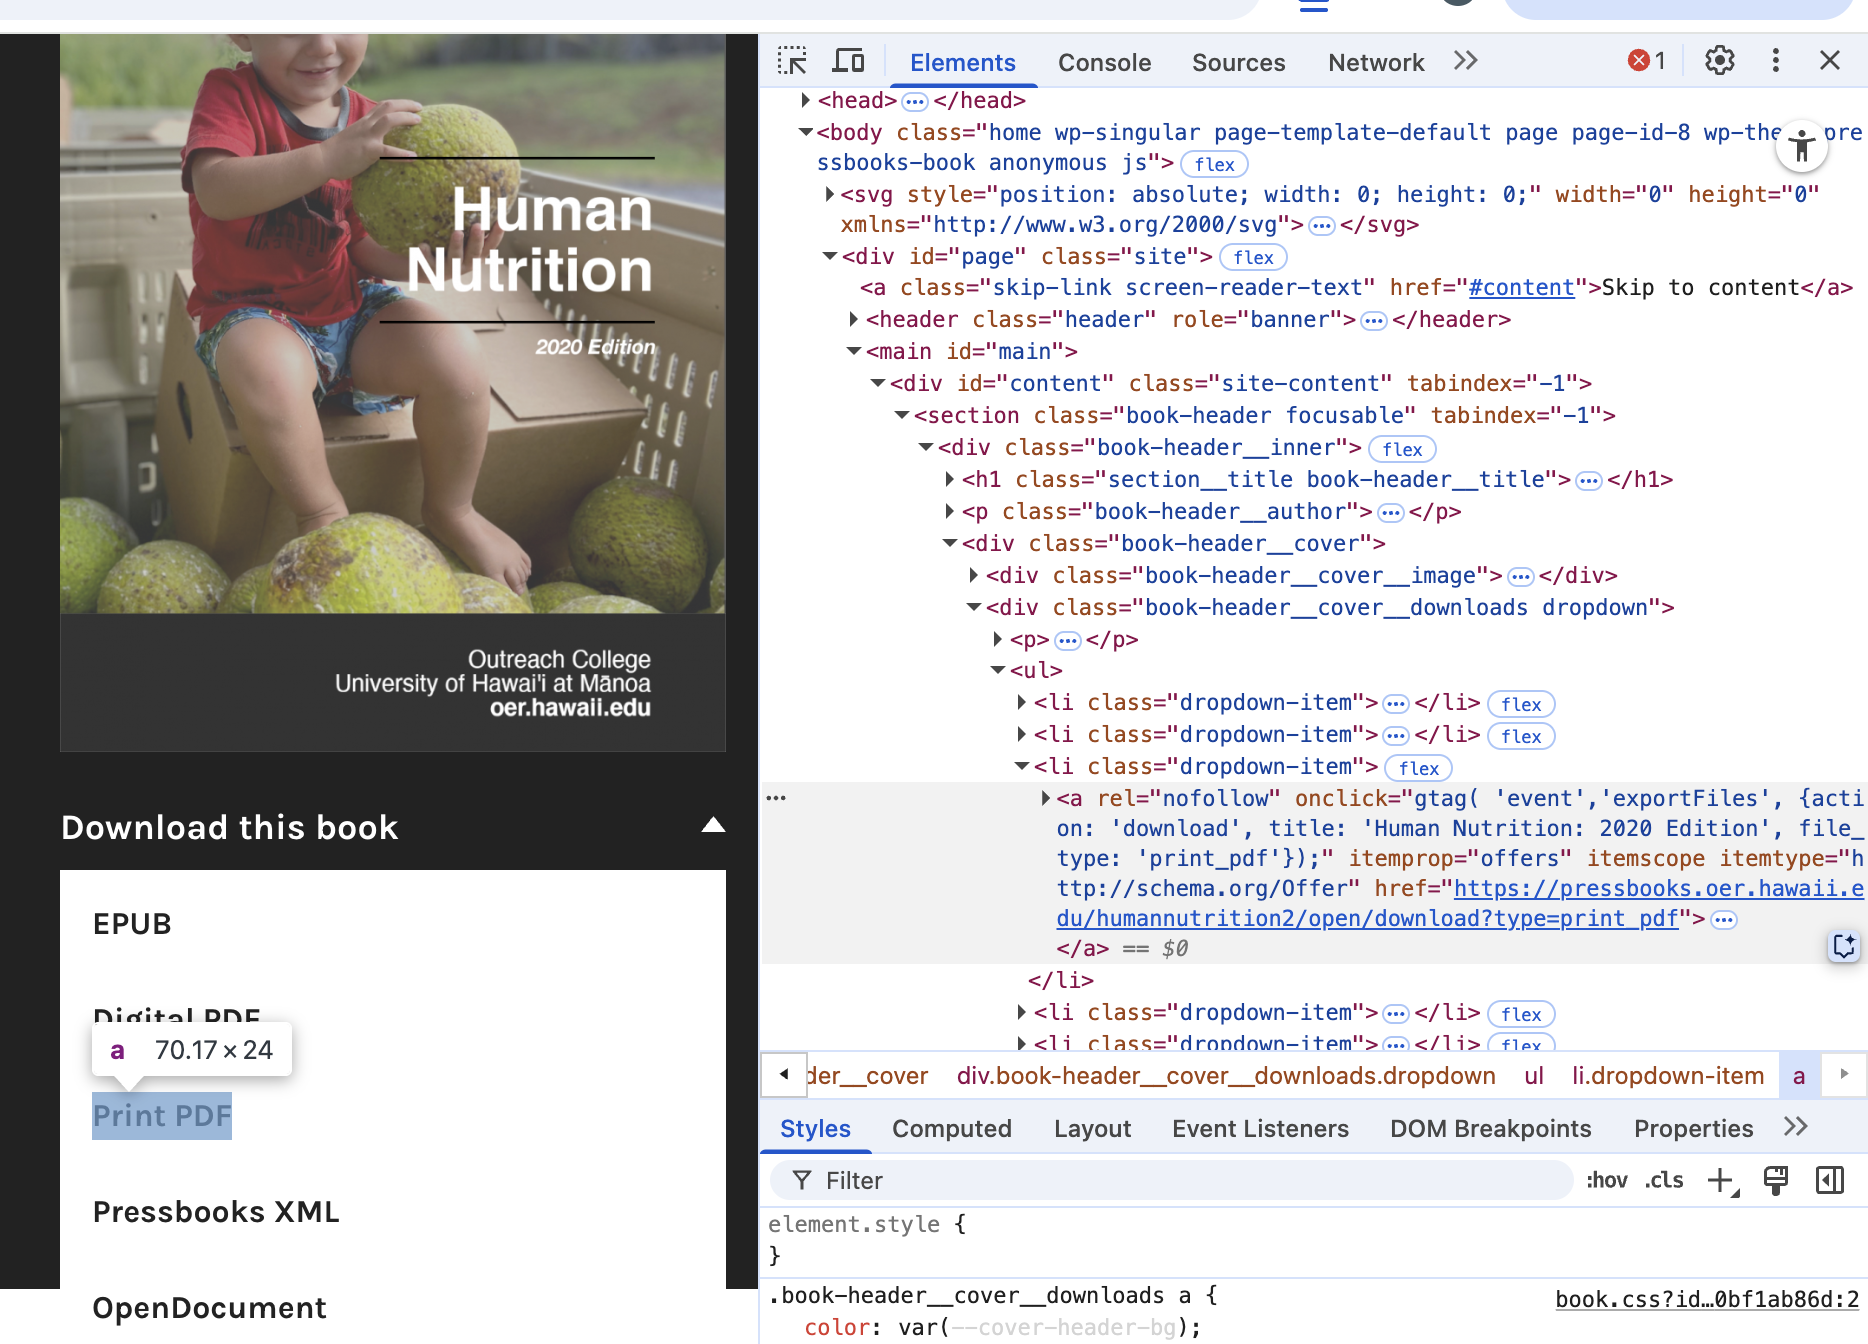

In [4]:
# Download PDF file
# Get PDF document
pdf_path = "human-nutrition-text.pdf"

# Download PDF if it doesn't already exist
if not os.path.exists(pdf_path):
  print("File doesn't exist, downloading...")

  # The URL of the PDF you want to download
  url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"

  # The local filename to save the downloaded file
  filename = pdf_path

  # Send a GET request to the URL
  response = requests.get(url)

  # Check if the request was successful
  if response.status_code == 200:
      # Open a file in binary write mode and save the content to it
      with open(filename, "wb") as file:
          file.write(response.content)
      print(f"The file has been downloaded and saved as {filename}")
  else:
      print(f"Failed to download the file. Status code: {response.status_code}")
else:
  print(f"File {pdf_path} exists.")

File human-nutrition-text.pdf exists.


PDF acquired!

We can import the pages of our PDF to text by first defining the PDF path and then opening and reading it with PyMuPDF (`import fitz`).

We'll write a small helper function to preprocess the text as it gets read. Note that not all text will be read in the same so keep this in mind for when you prepare your text.

We'll save each page to a dictionary and then append that dictionary to a list for ease of use later.

In [5]:
# Requires !pip install PyMuPDF, see: https://github.com/pymupdf/pymupdf
import fitz # (pymupdf, found this is better than pypdf for our use case, note: licence is AGPL-3.0, keep that in mind if you want to use any code commercially)

def text_formatter(text: str) -> str:
    """Performs minor formatting on text."""
    cleaned_text = text.replace("\n", " ").strip() # note: this might be different for each doc (best to experiment)

    # Other potential text formatting functions can go here
    return cleaned_text

# Open PDF and get lines/pages
# Note: this only focuses on text, rather than images/figures etc
def open_and_read_pdf(pdf_path: str) -> list[dict]:
    """
    Opens a PDF file, reads its text content page by page, and collects statistics.

    Parameters:
        pdf_path (str): The file path to the PDF document to be opened and read.

    Returns:
        list[dict]: A list of dictionaries, each containing the page number
        (adjusted), character count, word count, sentence count, token count, and the extracted text
        for each page.
    """
    doc = fitz.open(pdf_path)  # open a document
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):  # iterate the document pages
        text = page.get_text()  # get plain text encoded as UTF-8
        text = text_formatter(text)
        pages_and_texts.append({"page_number": page_number - 41,  # adjust page numbers since our PDF starts on page 42
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4,  # 1 token = ~4 chars, see: https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them
                                "text": text})
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[:2]

1208it [00:01, 878.95it/s]


[{'page_number': -41,
  'page_char_count': 29,
  'page_word_count': 4,
  'page_sentence_count_raw': 1,
  'page_token_count': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_number': -40,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''}]

Now let's get a random sample of the pages.

In [6]:
import random
random.sample(pages_and_texts, k=3)

[{'page_number': 382,
  'page_char_count': 765,
  'page_word_count': 126,
  'page_sentence_count_raw': 5,
  'page_token_count': 191.25,
  'text': 'Learning Activities  Technology Note: The second edition of the Human  Nutrition Open Educational Resource (OER) textbook  features interactive learning activities.  These activities are  available in the web-based textbook and not available in the  downloadable versions (EPUB, Digital PDF, Print_PDF, or  Open Document).  Learning activities may be used across various mobile  devices, however, for the best user experience it is strongly  recommended that users complete these activities using a  desktop or laptop computer and in Google Chrome.    An interactive or media element has been  excluded from this version of the text. You can  view it online here:  http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=254    382  |  Protein Digestion and Absorption'},
 {'page_number': 254,
  'page_char_count': 926,
  'page_word_count': 171,
  'page_se

### Get some stats on the text

Let's perform a rough exploratory data analysis (EDA) to get an idea of the size of the texts (e.g. character counts, word counts etc) we're working with.

The different sizes of texts will be a good indicator into how we should split our texts.

Many embedding models have limits on the size of texts they can ingest, for example, the [`sentence-transformers`](https://www.sbert.net/docs/pretrained_models.html) model [`all-mpnet-base-v2`](https://huggingface.co/sentence-transformers/all-mpnet-base-v2) has an input size of 384 tokens.

This means that the model has been trained in ingest and turn into embeddings texts with 384 tokens (1 token ~= 4 characters ~= 0.75 words).

Texts over 384 tokens which are encoded by this model will be auotmatically reduced to 384 tokens in length, potentially losing some information.

We'll discuss this more in the embedding section.

For now, let's turn our list of dictionaries into a DataFrame and explore it.

In [7]:
df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,1,1,0.00,
2,-39,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,-38,212,32,1,53.00,Human Nutrition: 2020 Edition by University of...
4,-37,797,147,3,199.25,Contents Preface University of Hawai‘i at Mā...


In [8]:
# Get stats
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,10.52,287.00
std,348.86,560.38,95.83,6.55,140.10
min,-41.00,0.00,1.00,1.00,0.00
25%,260.75,762.00,134.00,5.00,190.50
50%,562.50,1231.50,216.00,10.00,307.88
75%,864.25,1603.50,272.00,15.00,400.88
max,1166.00,2308.00,430.00,39.00,577.00


Okay, looks like our average token count per page is 287.

For this particular use case, it means we could embed an average whole page with the `all-mpnet-base-v2` model (this model has an input capacity of 384).

### Further text processing (splitting pages into sentences)

The ideal way of processing text before embedding it is still an active area of research.

A simple method I've found helpful is to break the text into chunks of sentences.

As in, chunk a page of text into groups of 5, 7, 10 or more sentences (these values are not set in stone and can be explored).

But we want to follow the workflow of:

`Ingest text -> split it into groups/chunks -> embed the groups/chunks -> use the embeddings`

Some options for splitting text into sentences:

1. Split into sentences with simple rules (e.g. split on ". " with `text = text.split(". ")`, like we did above).
2. Split into sentences with a natural language processing (NLP) library such as [spaCy](https://spacy.io/) or [nltk](https://www.nltk.org/).

Why split into sentences?

* Easier to handle than larger pages of text (especially if pages are densely filled with text).
* Can get specific and find out which group of sentences were used to help within a RAG pipeline.

> **Resource:** See [spaCy install instructions](https://spacy.io/usage). 

Let's use spaCy to break our text into sentences since it's likely a bit more robust than just using `text.split(". ")`. 

In [9]:
from spacy.lang.en import English # see https://spacy.io/usage for install instructions

nlp = English()

# Add a sentencizer pipeline, see https://spacy.io/api/sentencizer/ 
nlp.add_pipe("sentencizer")

# Create a document instance as an example
doc = nlp("This is a sentence. This another sentence.")
assert len(list(doc.sents)) == 2

# Access the sentences of the document
list(doc.sents)

[This is a sentence., This another sentence.]

We don't necessarily need to use spaCy, however, it's an open-source library designed to do NLP tasks like this at scale.

So let's run our small sentencizing pipeline on our pages of text.

In [10]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)
    
    # Make sure all sentences are strings
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]
    
    # Count the sentences 
    item["page_sentence_count_spacy"] = len(item["sentences"])

100%|██████████| 1208/1208 [00:01<00:00, 972.38it/s] 


In [11]:
# Inspect an example
random.sample(pages_and_texts, k=1)

[{'page_number': 647,
  'page_char_count': 849,
  'page_word_count': 144,
  'page_sentence_count_raw': 6,
  'page_token_count': 212.25,
  'text': 'Learning Activities  Technology Note: The second edition of the Human  Nutrition Open Educational Resource (OER) textbook  features interactive learning activities.  These activities are  available in the web-based textbook and not available in the  downloadable versions (EPUB, Digital PDF, Print_PDF, or  Open Document).  Learning activities may be used across various mobile  devices, however, for the best user experience it is strongly  recommended that users complete these activities using a  desktop or laptop computer and in Google Chrome.    An interactive or media element has been  excluded from this version of the text. You can  view it online here:  http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=372    An interactive or media element has been  excluded from this version of the text. You can  Summary of Major Minerals  |  647',
 

Wonderful!

Now let's turn out list of dictionaries into a DataFrame and get some stats.

In [12]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,10.52,287.00,10.32
std,348.86,560.38,95.83,6.55,140.10,6.30
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,260.75,762.00,134.00,5.00,190.50,5.00
50%,562.50,1231.50,216.00,10.00,307.88,10.00
75%,864.25,1603.50,272.00,15.00,400.88,15.00
max,1166.00,2308.00,430.00,39.00,577.00,28.00


For our set of text, it looks like our raw sentence count (e.g. splitting on `". "`) is quite close to what spaCy came up with.

Now we've got our text split into sentences, how about we gorup those sentences?

### Chunking our sentences together

Let's take a step to break down our list of sentences/text into smaller chunks.

As you might've guessed, this process is referred to as **chunking**.

Why do we do this?

1. Easier to manage similar sized chunks of text.
2. Don't overload the embedding models capacity for tokens (e.g. if an embedding model has a capacity of 384 tokens, there could be information loss if you try to embed a sequence of 400+ tokens).
3. Our LLM context window (the amount of tokens an LLM can take in) may be limited and requires compute power so we want to make sure we're using it as well as possible.

Something to note is that there are many different ways emerging for creating chunks of information/text.

For now, we're going to keep it simple and break our pages of sentences into groups of 10 (this number is arbitrary and can be changed, I just picked it because it seemed to line up well with our embedding model capacity of 384).

On average each of our pages has 10 sentences.

And an average total of 287 tokens per page.

So our groups of 10 sentences will also be ~287 tokens long.

This gives us plenty of room for the text to embedded by our `all-mpnet-base-v2` model (it has a capacity of 384 tokens).

To split our groups of sentences into chunks of 10 or less, let's create a function which accepts a list as input and recursively breaks into down into sublists of a specified size.

In [13]:
# Define split size to turn groups of sentences into chunks
num_sentence_chunk_size = 10 

# Create a function that recursively splits a list into desired sizes
def split_list(input_list: list, 
               slice_size: int) -> list[list[str]]:
    """
    Splits the input_list into sublists of size slice_size (or as close as possible).

    For example, a list of 17 sentences would be split into two lists of [[10], [7]]
    """
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

# Loop through pages and texts and split sentences into chunks
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

100%|██████████| 1208/1208 [00:00<00:00, 724230.88it/s]


In [14]:
# Sample an example from the group (note: many samples have only 1 chunk as they have <=10 sentences total)
random.sample(pages_and_texts, k=1)

[{'page_number': 518,
  'page_char_count': 891,
  'page_word_count': 156,
  'page_sentence_count_raw': 7,
  'page_token_count': 222.75,
  'text': 'Image by  Allison  Calabrese /  CC BY 4.0  One major difference between fat-soluble vitamins and water- soluble vitamins is the way they are absorbed in the body. Vitamins  are absorbed primarily in the small intestine and their bioavailability  is dependent on the food composition of the diet. Fat-soluble  vitamins are absorbed along with dietary fat. Therefore, if a meal  is very low in fat, the absorption of the fat-soluble vitamins will be  impaired. Once fat-soluble vitamins have been absorbed in the small  intestine, they are packaged and incorporated into chylomicrons  along with other fatty acids and transported in the lymphatic  system to the liver. Water-soluble vitamins on the other hand are  absorbed in the small intestine but are transported to the liver  through blood vessels.  Figure 9.2 “Absorption of Fat-Soluble and Water-So

In [15]:
# Create a DataFrame to get stats
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,10.52,287.00,10.32,1.53
std,348.86,560.38,95.83,6.55,140.10,6.30,0.64
min,-41.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,260.75,762.00,134.00,5.00,190.50,5.00,1.00
50%,562.50,1231.50,216.00,10.00,307.88,10.00,1.00
75%,864.25,1603.50,272.00,15.00,400.88,15.00,2.00
max,1166.00,2308.00,430.00,39.00,577.00,28.00,3.00


Note how the average number of chunks is around 1.5, this is expected since many of our pages only contain an average of 10 sentences.

### Splitting each chunk into its own item

We'd like to embed each chunk of sentences into its own numerical representation.

So to keep things clean, let's create a new list of dictionaries each containing a single chunk of sentences with relative information such as page number as well statistics about each chunk.

In [16]:
import re

# Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]
        
        # Join the sentences together into a paragraph-like structure, aka a chunk (so they are a single string)
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" -> ". A" for any full-stop/capital letter combo 
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get stats about the chunk
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 characters
        
        pages_and_chunks.append(chunk_dict)

# How many chunks do we have?
len(pages_and_chunks)

100%|██████████| 1208/1208 [00:00<00:00, 45108.47it/s]


1843

In [17]:
# View a random sample
random.sample(pages_and_chunks, k=1)

[{'page_number': 643,
  'sentence_chunk': 'Food Serving Magnesium (mg) Percent Daily Value Almonds 1 oz. 80 20 Cashews 1 oz. 74 19 Soymilk 1 c. 61 15 Black beans ½ c. 60 15 Edamame ½ c. 50 13 Bread 2 slices 46 12 Avocado 1 c. 44 11 Brown rice ½ c. 42 11 Yogurt 8 oz. 42 11 Oatmeal, instant 1 packet 36 9 Salmon 3 oz. 26 7 Chicken breasts 3 oz. 22 6 Apple 1 medium 9 2 Source: Dietary Supplement Fact Sheet: Magnesium. National Institutes of Health, Office of Dietary Supplements. http://ods.od.nih.gov/factsheets/Magnesium- HealthProfessional/. Updated July 13, 2009. Accessed November 12, 2017. Learning Activities Technology Note: The second edition of the Human Nutrition Open Educational Resource (OER) textbook features interactive learning activities.',
  'chunk_char_count': 714,
  'chunk_word_count': 120,
  'chunk_token_count': 178.5}]

Excellent!

Now we've broken our whole textbook into chunks of 10 sentences or less as well as the page number they came from.

This means we could reference a chunk of text and know its source.

Let's get some stats about our chunks.

In [18]:
# Get stats about our chunks
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,734.10,112.74,183.52
std,347.79,447.51,71.24,111.88
min,-41.00,12.00,3.00,3.00
25%,280.50,315.00,45.00,78.75
50%,586.00,745.00,115.00,186.25
75%,890.00,1118.00,173.00,279.50
max,1166.00,1830.00,297.00,457.50


Hmm looks like some of our chunks have quite a low token count.

How about we check for samples with less than 30 tokens (about the length of a sentence) and see if they are worth keeping?

In [19]:
# Show random chunks with under 30 tokens in length
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 10.75 | Text: Accessed December 10, 2017. 880 | Childhood
Chunk token count: 19.75 | Text: PART XVIII CHAPTER 18. NUTRITIONAL ISSUES Chapter 18. Nutritional Issues | 1041
Chunk token count: 10.5 | Text: Consequences of Deficiency or Excess | 205
Chunk token count: 3.25 | Text: 828 | Infancy
Chunk token count: 24.25 | Text: biological, chemicals, or physical) and identify preventative 1014 | Protecting the Public Health


Looks like many of these are headers and footers of different pages.

They don't seem to offer too much information.

Let's filter our DataFrame/list of dictionaries to only include chunks with over 30 tokens in length.

In [20]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_count': 308,
  'chunk_word_count': 42,
  'chunk_token_count': 77.0},
 {'page_number': -38,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
  'chunk_char_count': 210,
  'chunk_word_count': 30,
  'chunk_token_count': 52.5}]

Smaller chunks filtered!

Time to embed our chunks of text!

In [21]:
# Requires !pip install sentence-transformers
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", 
                                      device=device) # choose the device to load the model to (note: GPU will often be *much* faster than CPU)

# Create a list of sentences to turn into numbers
sentences = [
    "The Sentences Transformers library provides an easy and open-source way to create embeddings.",
    "Sentences can be embedded one by one or as a list of strings.",
    "Embeddings are one of the most powerful concepts in machine learning!",
    "Learn to use embeddings well and you'll be well on your way to being an AI engineer."
]

# Sentences are encoded/embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# See the embeddings
for sentence, embedding in embeddings_dict.items():
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

/opt/anaconda3/envs/LLM_RAG/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/anaconda3/envs/LLM_RAG/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sentence: The Sentences Transformers library provides an easy and open-source way to create embeddings.
Embedding: [-2.07981225e-02  3.03164907e-02 -2.01218501e-02  6.86483309e-02
 -2.55255606e-02 -8.47687665e-03 -2.07106248e-04 -6.32376671e-02
  2.81606410e-02 -3.33353542e-02  3.02634519e-02  5.30721061e-02
 -5.03526591e-02  2.62287520e-02  3.33313867e-02 -4.51578163e-02
  3.63044366e-02 -1.37112965e-03 -1.20170889e-02  1.14947148e-02
  5.04510365e-02  4.70857322e-02  2.11913269e-02  5.14607914e-02
 -2.03746445e-02 -3.58889401e-02 -6.67888438e-04 -2.94393152e-02
  4.95859459e-02 -1.05639603e-02 -1.52013786e-02 -1.31753250e-03
  4.48196232e-02  1.56023111e-02  8.60379487e-07 -1.21390633e-03
 -2.37978604e-02 -9.09460767e-04  7.34479912e-03 -2.53934553e-03
  5.23370430e-02 -4.68043275e-02  1.66214798e-02  4.71578613e-02
 -4.15599868e-02  9.01925901e-04  3.60278785e-02  3.42214108e-02
  9.68226865e-02  5.94829023e-02 -1.64984781e-02 -3.51249352e-02
  5.92515012e-03 -7.07956613e-04 -2.4103

Woah! That's a lot of numbers.

How about we do just once sentence?

In [22]:
single_sentence = "Yo! How cool are embeddings?"
single_embedding = embedding_model.encode(single_sentence)
print(f"Sentence: {single_sentence}")
print(f"Embedding:\n{single_embedding}")
print(f"Embedding size: {single_embedding.shape}")

Sentence: Yo! How cool are embeddings?
Embedding:
[-1.97447781e-02 -4.51075425e-03 -4.98479698e-03  6.55445009e-02
 -9.87667218e-03  2.72835344e-02  3.66425738e-02 -3.30219977e-03
  8.50083865e-03  8.24951101e-03 -2.28497814e-02  4.02430631e-02
 -5.75200021e-02  6.33692667e-02  4.43207361e-02 -4.49506417e-02
  1.25284474e-02 -2.52011754e-02 -3.55291814e-02  1.29559189e-02
  8.67025182e-03 -1.92917436e-02  3.55636282e-03  1.89506207e-02
 -1.47128766e-02 -9.39846132e-03  7.64175365e-03  9.62192472e-03
 -5.98928519e-03 -3.90169211e-02 -5.47824763e-02 -5.67458337e-03
  1.11645292e-02  4.08067182e-02  1.76319134e-06  9.15301777e-03
 -8.77262745e-03  2.39382479e-02 -2.32784897e-02  8.04998800e-02
  3.19176316e-02  5.12600411e-03 -1.47708151e-02 -1.62524506e-02
 -6.03213795e-02 -4.35688868e-02  4.51211482e-02 -1.79053936e-02
  2.63366699e-02 -3.47866677e-02 -8.89173336e-03 -5.47674373e-02
 -1.24373157e-02 -2.38606799e-02  8.33496451e-02  5.71242906e-02
  1.13328258e-02 -1.49594918e-02  9.2037

Nice! We've now got a way to numerically represent each of our chunks.

In [23]:
# Send the model to the GPU
embedding_model.to(device) # requires a GPU installed, for reference on my local machine, I'm using a NVIDIA RTX 4090

# Create embeddings one by one on the GPU
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

100%|██████████| 1680/1680 [01:22<00:00, 20.33it/s]


In [24]:
# Turn text chunks into a single list
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]

In [25]:
# Embed all texts in batches
text_chunk_embeddings = embedding_model.encode(text_chunks,
                                               batch_size=32, # you can use different batch sizes here for speed/performance, I found 32 works well for this use case
                                               convert_to_tensor=True) # optional to return embeddings as tensor instead of array

text_chunk_embeddings

tensor([[ 0.0674,  0.0902, -0.0051,  ..., -0.0221, -0.0232,  0.0126],
        [ 0.0552,  0.0592, -0.0166,  ..., -0.0120, -0.0103,  0.0227],
        [ 0.0280,  0.0340, -0.0206,  ..., -0.0054,  0.0213,  0.0313],
        ...,
        [ 0.0771,  0.0098, -0.0122,  ..., -0.0409, -0.0752, -0.0241],
        [ 0.1030, -0.0165,  0.0083,  ..., -0.0574, -0.0283, -0.0295],
        [ 0.0864, -0.0125, -0.0113,  ..., -0.0522, -0.0337, -0.0299]],
       device='mps:0')

### Save embeddings to file

Since creating embeddings can be a timely process (not so much for our case but it can be for more larger datasets), let's turn our `pages_and_chunks_over_min_token_len` list of dictionaries into a DataFrame and save it.

In [26]:
# Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

And we can make sure it imports nicely by loading it.

In [27]:
# Import saved file and view
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,[ 6.74242526e-02 9.02282819e-02 -5.09550283e-...
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,[ 5.52156232e-02 5.92139177e-02 -1.66167207e-...
2,-37,Contents Preface University of Hawai‘i at Māno...,766,116,191.50,[ 2.79801786e-02 3.39814313e-02 -2.06426587e-...
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,144,235.25,[ 6.82566985e-02 3.81275080e-02 -8.46854784e-...
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,[ 3.30264233e-02 -8.49770568e-03 9.57160536e-...


### Chunking and embedding questions

> **Which embedding model should I use?**

This depends on many factors. My best advice is to experiment, experiment, experiment! 

If you want the model to run locally, you'll have to make sure it's feasible to run on your own hardware. 

A good place to see how different models perform on a wide range of embedding tasks is the [Hugging Face Massive Text Embedding Benchmark (MTEB) Leaderboard](https://huggingface.co/spaces/mteb/leaderboard).

> **What other forms of text chunking/splitting are there?**

There are a fair few options here too. We've kept it simple with groups of sentences.

For more, [Pinecone has a great guide on different kinds of chunking](https://www.pinecone.io/learn/chunking-strategies/) including for different kinds of data such as markdown and LaTeX.

Libraries such as [LangChain also have a good amount of in-built text splitting options](https://python.langchain.com/docs/modules/data_connection/document_transformers/).

> **What should I think about when creating my embeddings?**

Our model turns text inputs up to 384 tokens long in embedding vectors of size 768.

Generally, the larger the vector size, the more information that gets encoded into the embedding (however, this is not always the case, as smaller, better models can outperform larger ones).

Though with larger vector sizes comes larger storage and compute requirements.

Our model is also relatively small (420MB) in size compared to larger models that are available.

Larger models may result in better performance but will also require more compute.

So some things to think about:
* Size of input - If you need to embed longer sequences, choose a model with a larger input capacity.
* Size of embedding vector - Larger is generally a better representation but requires more compute/storage.
* Size of model - Larger models generally result in better embeddings but require more compute power/time to run.
* Open or closed - Open models allow you to run them on your own hardware whereas closed models can be easier to setup but require an API call to get embeddings.

> **Where should I store my embeddings?**

If you've got a relatively small dataset, for example, under 100,000 examples (this number is rough and only based on first hand experience), `np.array` or `torch.tensor` can work just fine as your dataset.

But if you've got a production system and want to work with 100,000+ embeddings, you may want to look into a [vector database]( https://en.wikipedia.org/wiki/Vector_database) (these have become very popular lately and there are many offerings).

### Document Ingestion and Embedding Creation Extensions

One major extension to the workflow above would to functionize it.

Or turn it into a script.

As in, take all the functionality we've created and package it into a single process (e.g. go from document -> embeddings file).

So you could input a document on one end and have embeddings come out the other end. The hardest part of this is knowing what kind of preprocessing your text may need before it's turned into embeddings. Cleaner text generally means better results.



## 2. RAG - Search and Answer

We discussed RAG briefly in the beginning but let's quickly recap.

RAG stands for Retrieval Augmented Generation.

Which is another way of saying "given a query, search for relevant resources and answer based on those resources".

Let's breakdown each step:
* **Retrieval** - Get relevant resources given a query. For example, if the query is "what are the macronutrients?" the ideal results will contain information about protein, carbohydrates and fats (and possibly alcohol) rather than information about which tractors are the best for farming (though that is also cool information).
* **Augmentation** - LLMs are capable of generating text given a prompt. However, this generated text is designed to *look* right. And it often has some correct information, however, they are prone to hallucination (generating a result that *looks* like legit text but is factually wrong). In augmentation, we pass relevant information into the prompt and get an LLM to use that relevant information as the basis of its generation.
* **Generation** - This is where the LLM will generate a response that has been flavoured/augmented with the retrieved resources. In turn, this not only gives us a potentially more correct answer, it also gives us resources to investigate more (since we know which resources went into the prompt).

The whole idea of RAG is to get an LLM to be more factually correct based on your own input as well as have a reference to where the generated output may have come from.

This is an incredibly helpful tool.

Let's say you had 1000s of customer support documents.

You could use RAG to generate direct answers to questions with links to relevant documentation.

Or you were an insurance company with large chains of claims emails.

You could use RAG to answer questions about the emails with sources.

One helpful analogy is to think of LLMs as calculators for words.

With good inputs, the LLM can sort them into helpful outputs.

How? 

It starts with better search.

### Similarity search

Similarity search or semantic search or vector search is the idea of searching on *vibe*.

If this sounds like woo, woo. It's not.

Perhaps searching via *meaning* is a better analogy.

With keyword search, you are trying to match the string "apple" with the string "apple".

Whereas with similarity/semantic search, you may want to search "macronutrients functions".

And get back results that don't necessarily contain the words "macronutrients functions" but get back pieces of text that match that meaning.

> **Example:** Using similarity search on our textbook data with the query "macronutrients function" returns a paragraph that starts with: 
>
>*There are three classes of macronutrients: carbohydrates, lipids, and proteins. These can be metabolically processed into cellular energy. The energy from macronutrients comes from their chemical bonds. This chemical energy is converted into cellular energy that is then utilized to perform work, allowing our bodies to conduct their basic functions.*
> 
> as the first result. How cool!

If you've ever used Google, you know this kind of workflow.

But now we'd like to perform that across our own data.

Let's import our embeddings we created earlier (tk -link to embedding file) and prepare them for use by turning them into a tensor.